In [1]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from torch.autograd import Variable
import random
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
def tokenize_and_pad(transformer_model, sentences):
    """ We are using .encode_plus. This does not make specialized attn masks 
        like in our selectional preferences experiment. Revert to .encode if
        necessary."""
    
    input_ids = []
    segment_ids = [] # token type ids
    attention_masks = []
    
    if transformer_model.split("-")[0] == 'bert':
        tok = BertTokenizer.from_pretrained(transformer_model)
    elif transformer_model.split("-")[0] == 'roberta':
        tok = RobertaTokenizer.from_pretrained(transformer_model)
    elif transformer_model.split("-")[0] == 'albert':
        tok = AlbertTokenizer.from_pretrained(transformer_model)
    elif transformer_model.split("-")[0] == 'xlnet':
        tok = XLNetTokenizer.from_pretrained(transformer_model)
    elif 'camembert' in transformer_model:
        tok = CamembertTokenizer.from_pretrained(transformer_model)
    elif 'flaubert' in transformer_model:
        tok = FlaubertTokenizer.from_pretrained(transformer_model)

    for sent in sentences:
        sentence = sent[0]

        # encode_plus is a prebuilt function that will make input_ids, 
        # add padding/truncate, add special tokens, + make attention masks 
        encoded_dict = tok.encode_plus(
                        sentence,                      
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,      # Pad & truncate all sentences.
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True, # Construct attn. masks.
                        # return_tensors = 'pt',     # Return pytorch tensors.
                   )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # Add segment ids, add 1 for verb idx
        segment_id = encoded_dict['token_type_ids']
        segment_id[sent[2]] = 1
        segment_ids.append(segment_id)

        attention_masks.append(encoded_dict['attention_mask'])

    return input_ids, attention_masks, segment_ids


def decode_result(transformer_model, encoded_sequence):

    if transformer_model.split("-")[0] == 'bert':
        tok = BertTokenizer.from_pretrained(transformer_model)
    elif transformer_model.split("-")[0] == 'roberta':
        tok = RobertaTokenizer.from_pretrained(transformer_model)
    elif transformer_model.split("-")[0] == 'albert':
        tok = AlbertTokenizer.from_pretrained(transformer_model)
    elif transformer_model.split("-")[0] == 'xlnet':
        tok = XLNetTokenizer.from_pretrained(transformer_model)
    elif 'camembert' in transformer_model:
        tok = CamembertTokenizer.from_pretrained(transformer_model)
    elif 'flaubert' in transformer_model:
        tok = FlaubertTokenizer.from_pretrained(transformer_model)
    
    # decode + remove special tokens
    tokens_to_remove = ['[PAD]', '<pad>', '<s>', '</s>']
    decoded_sequence = [w.replace('Ġ', '').replace('▁', '').replace('</w>', '')
                        for w in list(tok.convert_ids_to_tokens(encoded_sequence))
                        if not w.strip() in tokens_to_remove]
    
    return decoded_sequence

In [37]:
# load finetuned model

model = BertForSequenceClassification.from_pretrained('checkpoints/friedrich_captions_data/telicity/bert-base-uncased_no')
tokenizer_model = 'bert-base-uncased'

In [38]:
# open unseen test set

test_sentences = []
test_labels = []
    
# with open('data/unseen_tests/telicity_unseen_test.tsv', 'r', encoding='utf-8') as f: # qualitative test 1
with open('data/unseen_tests/telicity_min_pairs.tsv', 'r', encoding='utf-8') as f:     # minimal pairs test set
    for line in f:
        l = line.strip().split('\t')
        test_sentences.append([l[-4], l[-3], int(l[-2])])
        test_labels.append(int(l[-1]))

use_segment_ids = False
test_inputs, test_masks, test_segments = tokenize_and_pad(tokenizer_model, test_sentences)

test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_masks)
test_segments = torch.tensor(test_segments)

In [39]:
# Return attentions for each sentence of the test set, attentions per sentence (not batched per layer)

model.eval()

all_inputs = []
sent_attentions = []
sentences = []

for inputs in test_inputs:
    
    test_input = inputs.resize(1, 128)
    
    with torch.no_grad():        
        outputs = model(test_input, 
                        token_type_ids=None, 
                        attention_mask=None)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    attentions = outputs[1]
    
    sentence = decode_result(tokenizer_model, inputs)
    sentences.append(sentence)
    len_sequence = len(sentence)
    
    temp_attentions = [] # turn attention to (layer, head, size, size)
    
    for layer in attentions:
        temp = torch.squeeze(layer) #remove dimension of batch size = 1
        temp = np.array(temp)[:, :len_sequence, :len_sequence]
        temp_attentions.append(temp)
        
    sent_attentions.append(np.asarray(temp_attentions))

/users/melodi/emetheni/.local/lib/python3.6/site-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [40]:
width = 3
example_sep = 3
word_height = 1
pad = 0.1

def plot_attn(sentence, attentions, layer, heads):
    """Plots attention maps for the given example and attention heads."""

    for ei, head in enumerate(heads):
        yoffset = 1
        xoffset = ei * width * example_sep

        attn = attentions[layer][head]
        attn = np.array(attn)
        attn /= attn.sum(axis=-1, keepdims=True)
        words = sentence
        n_words = len(words)

        for position, word in enumerate(words):
            plt.text(xoffset + 0, yoffset - position * word_height, word,
                   ha="right", va="center")
            plt.text(xoffset + width, yoffset - position * word_height, word,
                   ha="left", va="center")
        for i in range(1, n_words):
            for j in range(1, n_words):
                plt.plot([xoffset + pad, xoffset + width - pad],
                 [yoffset - word_height * i, yoffset - word_height * j],
                 color="blue", linewidth=1, alpha=attn[i, j])


[CLS] the boy is eating apples . [SEP] 	label: 1

Layer: 1 



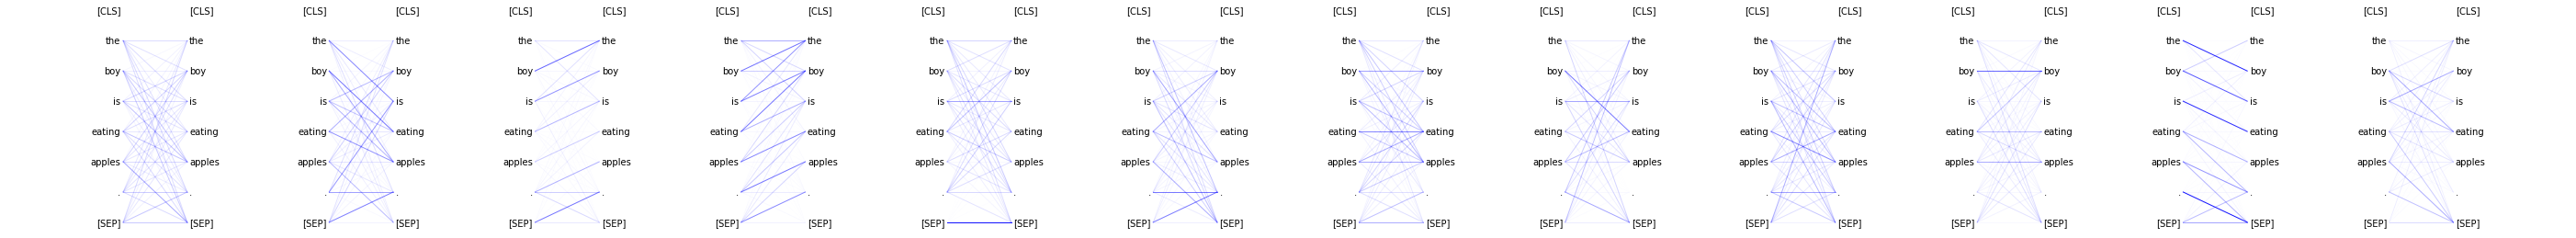


Layer: 2 



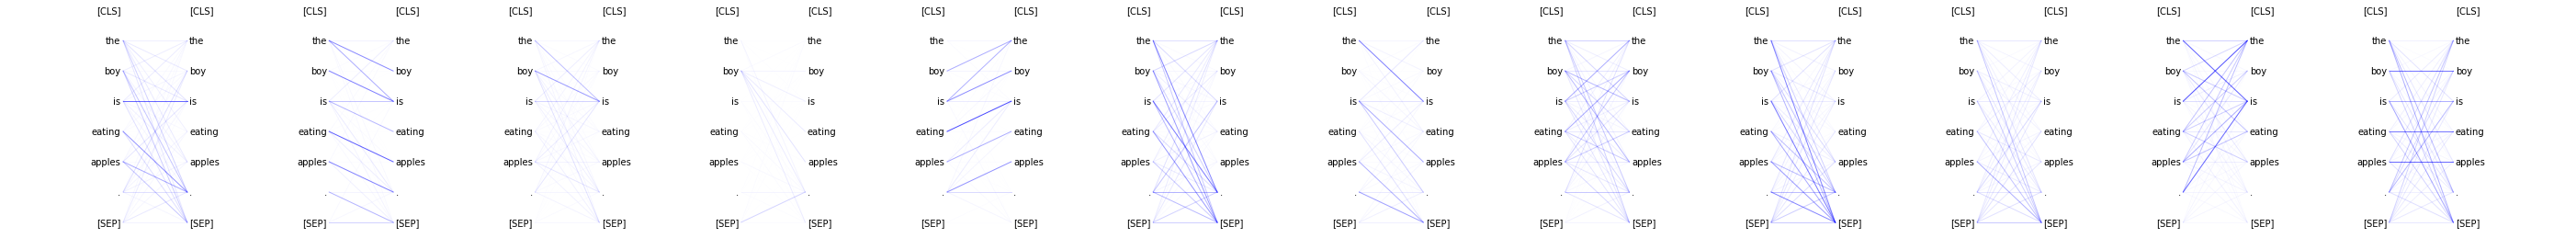


Layer: 3 



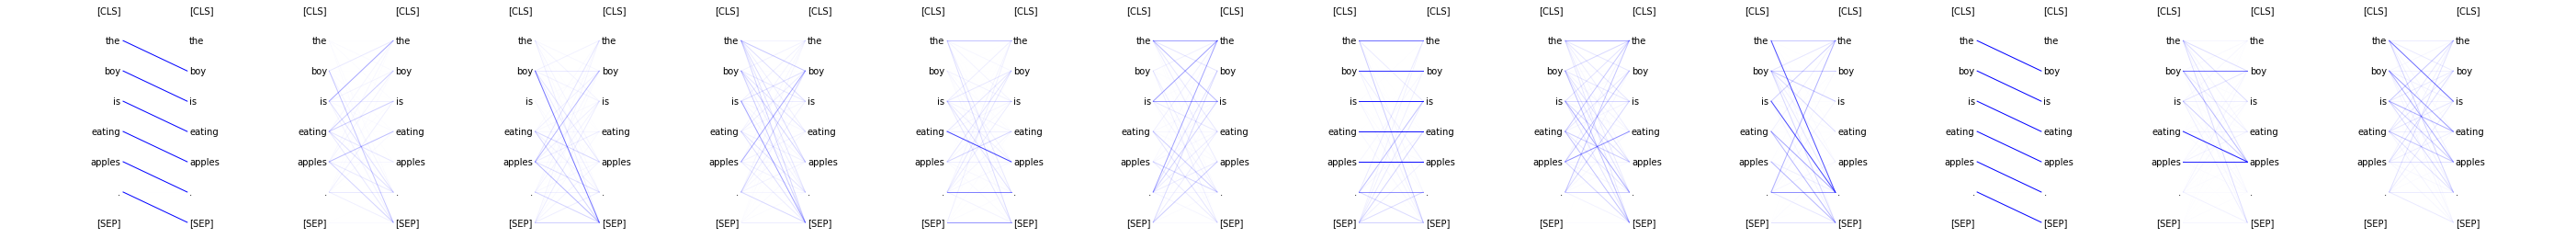


Layer: 4 



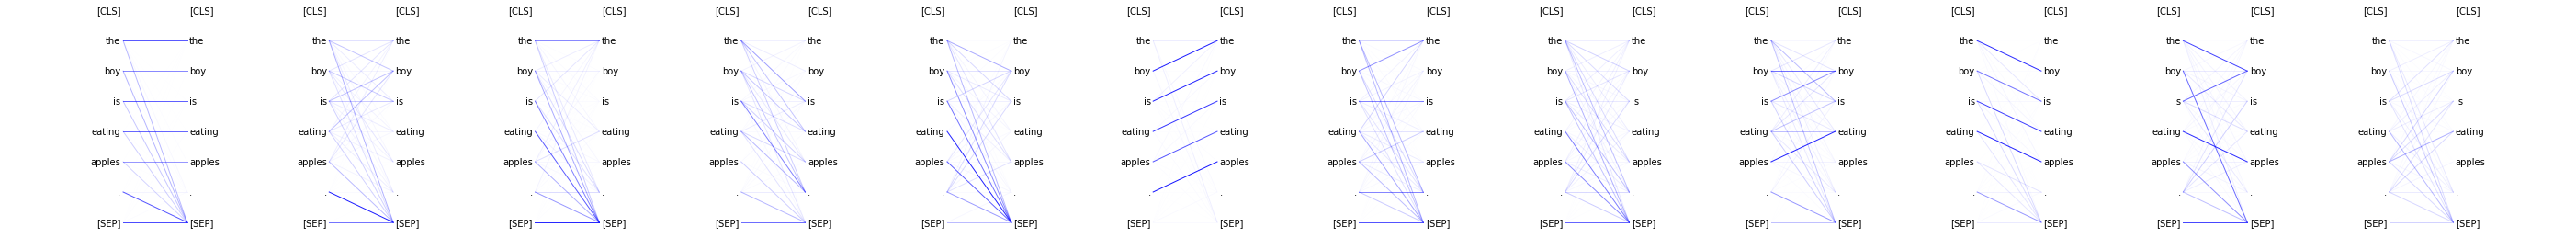


Layer: 5 



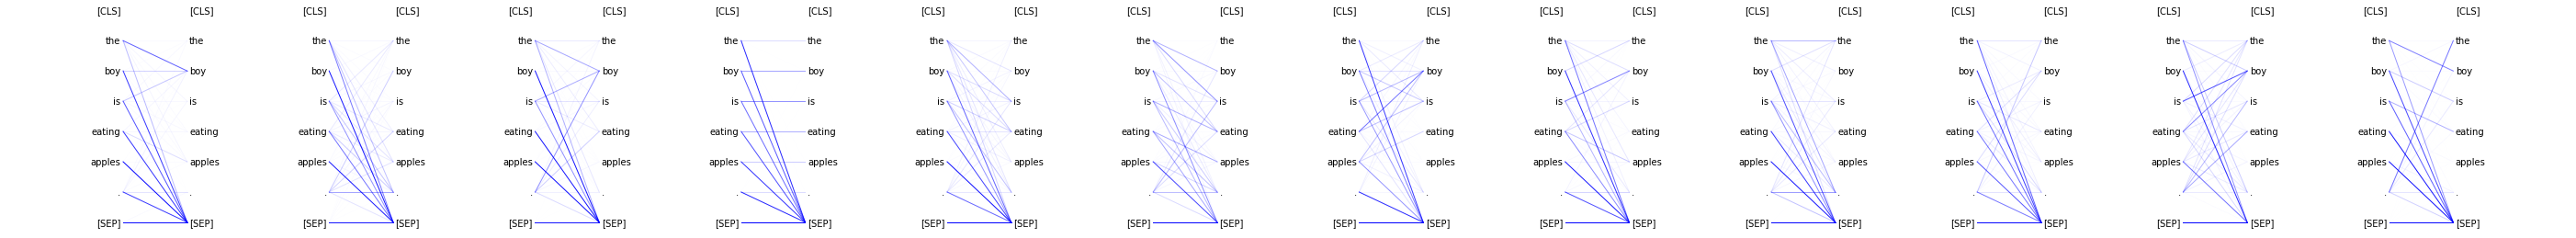


Layer: 6 



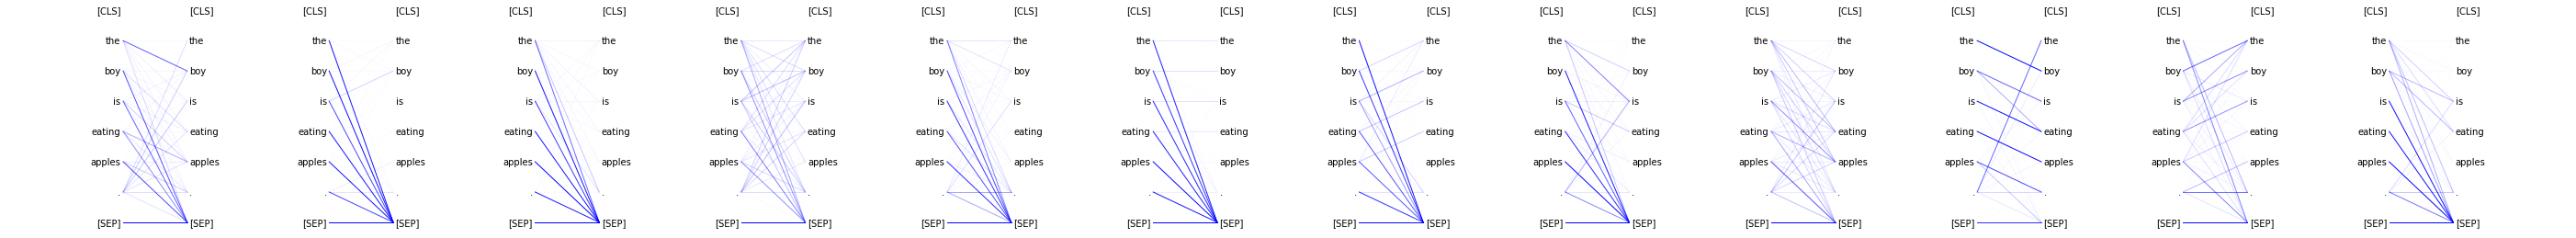


Layer: 7 



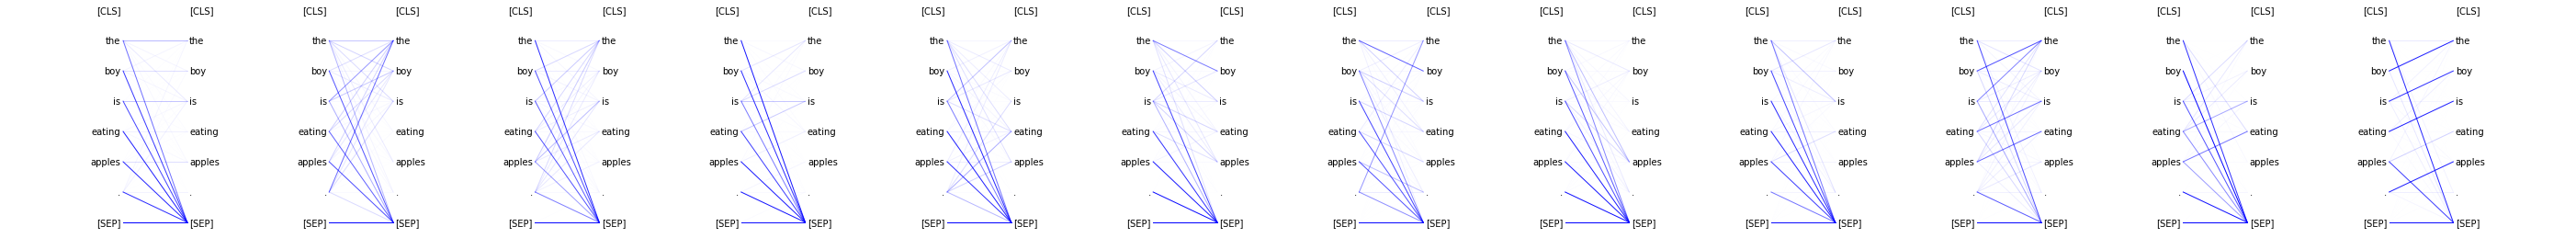


Layer: 8 



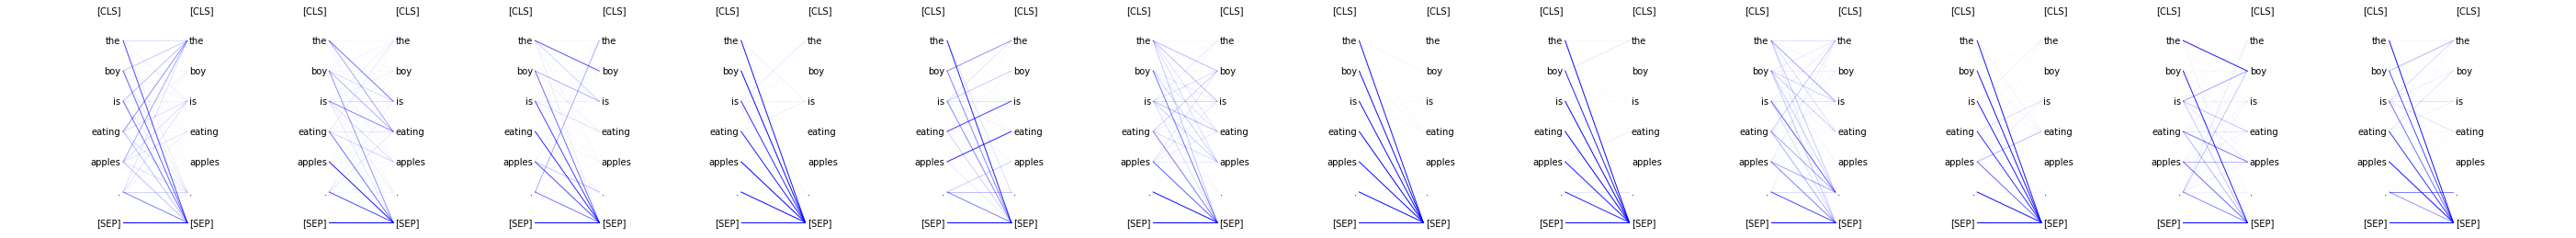


Layer: 9 



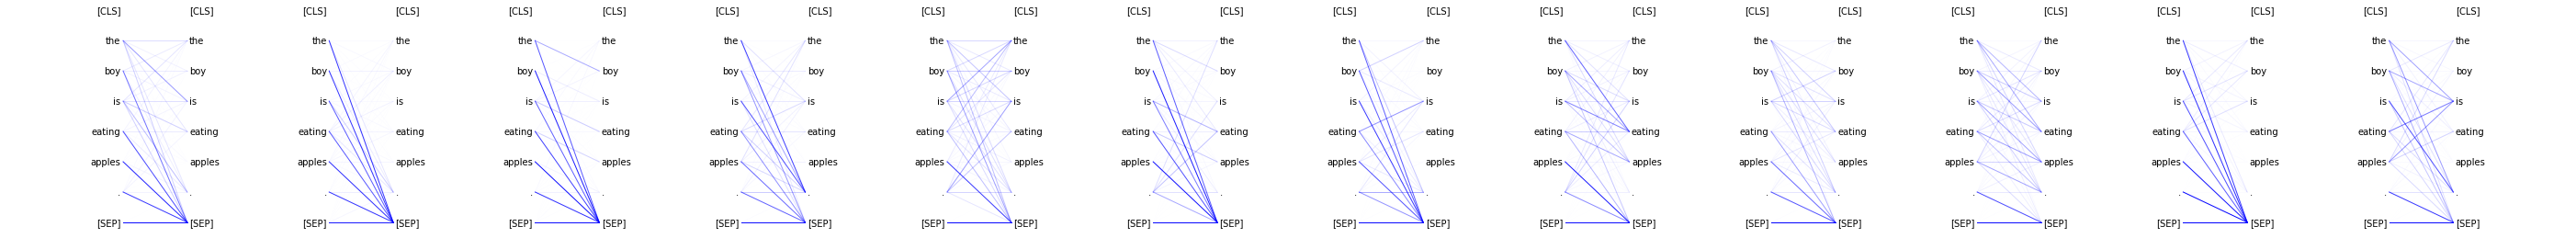


Layer: 10 



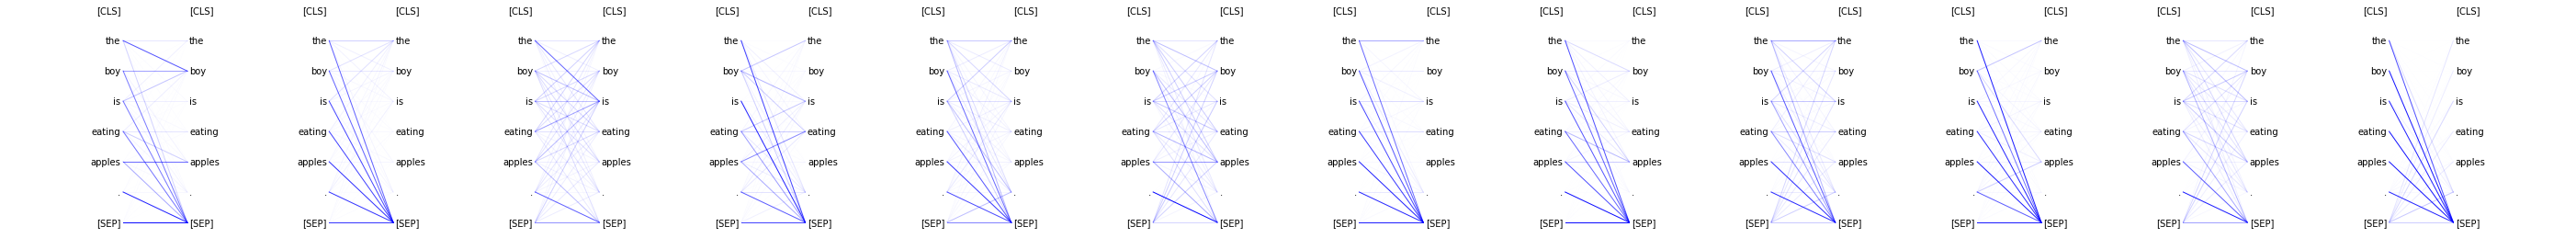


Layer: 11 



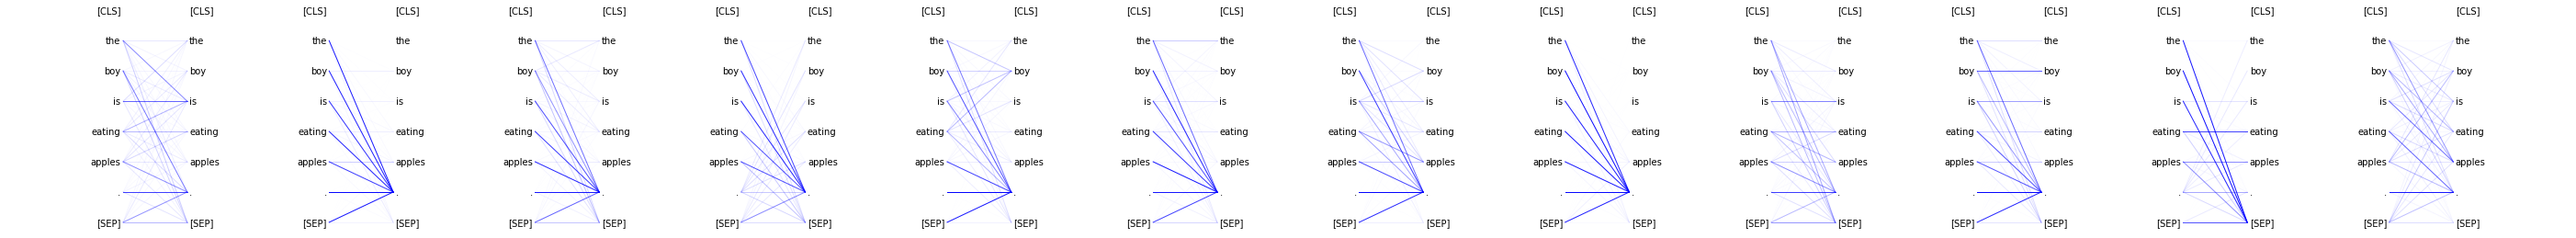


Layer: 12 



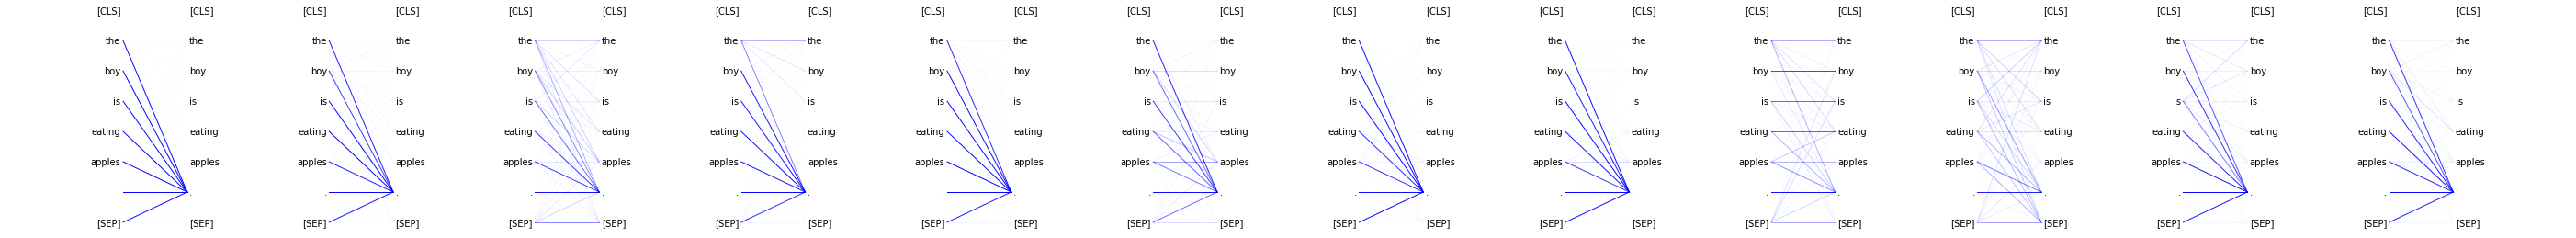

In [60]:
# Select a sentence, layer and heads
# layer = 0
heads = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
sent_idx = 5
print(' '.join(sentences[sent_idx]), '\tlabel:', int(test_labels[sent_idx]))

for layer in range(12):
    print('\nLayer:', layer+1, '\n')
    plt.figure(figsize=(50, 4))
    plt.axis("off")
    plot_attn(sentences[sent_idx], sent_attentions[sent_idx], layer, heads)
    plt.show()

In [61]:
# sent_idx = 2 # target_sentence
len_sequence = len(sentences[sent_idx])

attentions_pos = sent_attentions[sent_idx]
attentions_pos = torch.FloatTensor(attentions_pos).permute(2,1,0,3)

verb_idx = test_segments[sent_idx].tolist().index(1) + 1 # add 1 for the [CLS] token

Sentence:  [CLS] the boy is eating apples . [SEP]
Attention weights for token:  eating


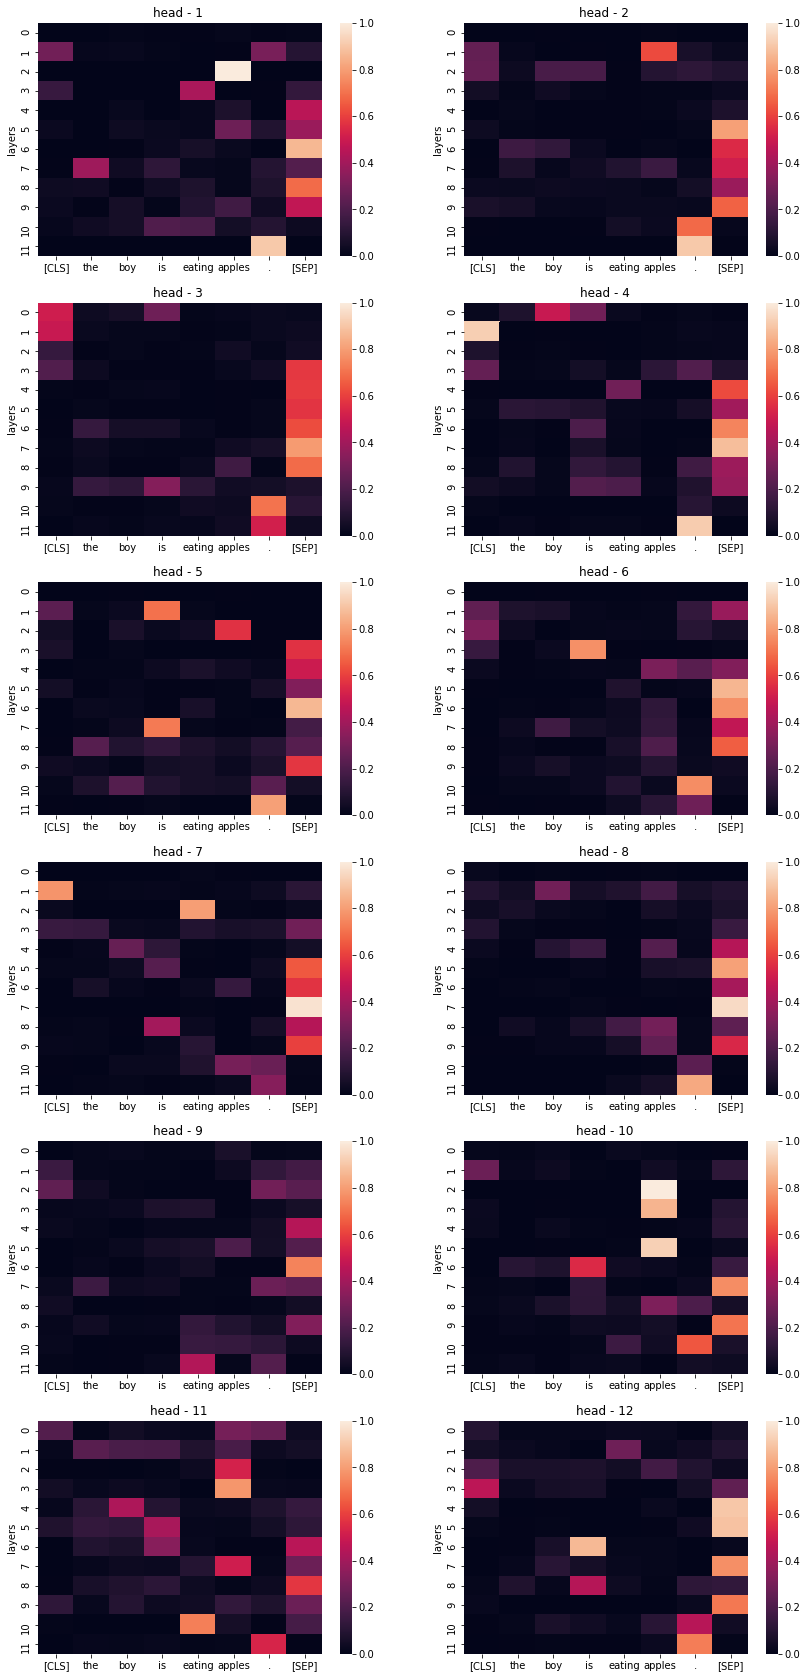

In [62]:
#Plot Attention for specifically the verb

cols = 2
heads = 12
rows = int(heads/cols)

fig, axes = plt.subplots(rows, cols, figsize = (14,30))
axes = axes.flat
print('Sentence: ', ' '.join(sentences[sent_idx]))
print ('Attention weights for token: ', sentences[sent_idx][verb_idx])

for i, att in enumerate(attentions_pos[verb_idx]):
    #im = axes[i].imshow(att, cmap='gray')
    sns.heatmap(att, vmin = 0, vmax = 1, ax = axes[i], xticklabels = sentences[sent_idx])
    axes[i].set_title(f'head - {i+1} ' )
    axes[i].set_ylabel('layers')